<a href="https://colab.research.google.com/github/esuda/mineiracao_dados_complexos/blob/master/Trabalho_Final_Draft_Eric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Projeto Final - Mineração de Dados Complexos***

# 0) Setup

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.475606071002403
GPU (s):
0.03710129999672063
GPU speedup over CPU: 39x


In [3]:
import gc
import re

import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
import random
from PIL import Image
from matplotlib import image

import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.metrics import Metric
from tensorflow.python.keras.utils import metrics_utils
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.keras.utils.generic_utils import to_list
from tensorflow.keras.metrics import Recall, SpecificityAtSensitivity
from tensorflow.python.ops import math_ops
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, Dense, Flatten, Dropout,
    GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, MaxPool2D
)
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from keras.layers.merge import concatenate

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cmx


tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")

import os

# 1) Importando bases do kaggle

In [4]:
from google.colab import files
files.upload()

{}

In [5]:
! pip install kaggle==1.5.6
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
! mkdir projeto_final

mkdir: cannot create directory ‘projeto_final’: File exists


In [8]:
! kaggle competitions download -c plant-pathology-2021-fgvc8 -p "projeto_final/"

plant-pathology-2021-fgvc8.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!unzip "projeto_final/plant-pathology-2021-fgvc8.zip" -d "/projeto_final/"

Archive:  projeto_final/plant-pathology-2021-fgvc8.zip
replace /projeto_final/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# 2) EDA

### 2.1) Carregando os datasets

In [7]:
TEST_PATH = "../projeto_final/sample_submission.csv"
TRAIN_PATH = "../projeto_final/train.csv"

In [8]:
df_train = pd.read_csv(TRAIN_PATH)
df_test=pd.read_csv(TEST_PATH)

In [9]:
df_train["labels"].value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

#### Preparacao do dataset

In [10]:
# Ajustando labels com onehot encoding

df_train["label_list"] = df_train["labels"].str.split(" ")

df_train.head()

,image,labels,label_list
0,800113bb65efe69e.jpg,healthy,[healthy]
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,scab,[scab]
3,80077517781fb94f.jpg,scab,[scab]
4,800cbf0ff87721f8.jpg,complex,[complex]


In [11]:
# Metodo 1 de oneohot ecoding

def onehot_label(col, label_list):
  if col in label_list:
    onehot = 1
  else:
    onehot = 0
  
  return onehot
  
label_list = df_train[df_train["label_list"].str.len() == 1]["labels"].unique()

for label in label_list:
  df_train[label] = 0

for label in label_list:
  df_train[label] = np.vectorize(onehot_label)(label, df_train["label_list"])

In [12]:
# Metodo 2 onehot encoding

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df_mlb = pd.DataFrame(mlb.fit_transform(df_train["label_list"]),columns=mlb.classes_)

# Apenas para validar ambos os jeitos
df_train.join(df_mlb, how="left", lsuffix="_first_method", rsuffix="_second_method").head()

,image,labels,label_list,healthy_first_method,scab_first_method,complex_first_method,rust_first_method,frog_eye_leaf_spot_first_method,powdery_mildew_first_method,complex_second_method,frog_eye_leaf_spot_second_method,healthy_second_method,powdery_mildew_second_method,rust_second_method,scab_second_method
0,800113bb65efe69e.jpg,healthy,[healthy],1,0,0,0,0,0,0,0,1,0,0,0
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,"[scab, frog_eye_leaf_spot, complex]",0,1,1,0,1,0,1,1,0,0,0,1
2,80070f7fb5e2ccaa.jpg,scab,[scab],0,1,0,0,0,0,0,0,0,0,0,1
3,80077517781fb94f.jpg,scab,[scab],0,1,0,0,0,0,0,0,0,0,0,1
4,800cbf0ff87721f8.jpg,complex,[complex],0,0,1,0,0,0,1,0,0,0,0,0


In [13]:
# Gera a coluna com a lista de labels a serem preditos
df_train["target"] = df_train[label_list].astype('float32').values.tolist()

In [14]:
print("labels estao na ordem: ")
print(label_list)

labels estao na ordem: 
['healthy' 'scab' 'complex' 'rust' 'frog_eye_leaf_spot' 'powdery_mildew']


### Tecnicas de processamento de imagem

#### Deteccao de bordas e bounding box

In [15]:
def edge_and_cut(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
    
    row_min = edge_coors[np.argsort([coor[0] for coor in edge_coors])[0]][0]
    row_max = edge_coors[np.argsort([coor[0] for coor in edge_coors])[-1]][0]
    col_min = edge_coors[np.argsort([coor[1] for coor in edge_coors])[0]][1]
    col_max = edge_coors[np.argsort([coor[1] for coor in edge_coors])[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]
    
    emb_img[row_min-10:row_min+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_max-10:row_max+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_min:row_max, col_min-10:col_min+10] = [255, 0, 0]
    emb_img[row_min:row_max, col_max-10:col_max+10] = [255, 0, 0]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=24)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=24)
    plt.show()

### Preparacao do dataset para treinar o modelo

In [16]:
img_height = 256
img_width = 256
batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

In [17]:
def format_path(image:str)->str:
  return "/projeto_final/train_images/"+image

In [18]:
image_count = len(list(df_train.image))

train_paths = df_train["image"].apply(format_path).values

list_ds = tf.data.Dataset.from_tensor_slices((train_paths, np.vstack(df_train.target).astype(np.float)))

#dividir em treino e validação
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [19]:
train_paths

array(['/projeto_final/train_images/800113bb65efe69e.jpg',
       '/projeto_final/train_images/8002cb321f8bfcdf.jpg',
       '/projeto_final/train_images/80070f7fb5e2ccaa.jpg', ...,
       '/projeto_final/train_images/fffc94e092a59086.jpg',
       '/projeto_final/train_images/fffe105cf6808292.jpg',
       '/projeto_final/train_images/fffe472a0001bd25.jpg'], dtype=object)

In [20]:
def decode_img(img, rescale=255.0):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Rescale
  # img = tf.cast(img, tf.float32)/rescale
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


def process_path(file_path, labels):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, labels

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [21]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## Modelo Baseline

In [22]:
CLASSES = label_list

F1_score = tfa.metrics.F1Score(
    num_classes= len(CLASSES),
    average = 'weighted',
)

In [23]:
# Carregamento do modelo pré-treinado SEM as camadas densas (include_top = False)
model = tf.keras.applications.ResNet50(weights='imagenet', 
                                       include_top=False, 
                                       input_shape=(256,256,3)) # 32 x 32 (?)
#model.summary()

# Congela camadas pré-treinadas
for layer in model.layers:
    layer.trainable = False

In [24]:
# Insere novas camadas no fim da rede para classificação
frozen_model_without_rescaling = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(CLASSES), activation='sigmoid')
])

frozen_model_without_rescaling.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


In [25]:
def vanilla_model(model,
                  train_ds,
                  val_ds,
                  learning_rate=0.001,
                  momentum=0.9,
                  decay=0.001,
                  nesterov=True,
                  monitor='val_loss',
                  patience=5,
                  filepath='model_x.h5',
                  epochs=100,
                  batches=100):
  
  # Instancia um otimizador SGD, compila e treina o modelo completo
  sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, 
                                momentum=momentum, 
                                decay=decay, 
                                nesterov=nesterov)


  # Early Stopping
  early = tf.keras.callbacks.EarlyStopping(monitor=monitor, 
                                          patience=patience, 
                                          restore_best_weights=True)
  # Checkpoint
  filepath = './content/drive/MyDrive/projeto_final_modelos/'+filepath
  checkpoint = ModelCheckpoint(filepath, 
                              monitor=monitor,
                              save_best_only=True,
                              mode='max')
  callbacks = [early, checkpoint]

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                                        optimizer=sgd, 
                                        metrics=[F1_score])

  history = model.fit(train_ds, 
                            epochs=100, 
                            callbacks=callbacks,
                            validation_data=val_ds)
  return history

In [26]:
history = vanilla_model(frozen_model_without_rescaling,
                         train_ds,
                         val_ds,
                         filepath='vanilla_resnet50_rescale.h5')

Epoch 1/100
117/117 [==============================] - 631s 5s/step - loss: 0.4656 - f1_score: 0.2053 - val_loss: 0.4522 - val_f1_score: 0.0737
Epoch 2/100
117/117 [==============================] - 36s 304ms/step - loss: 0.4458 - f1_score: 0.1953 - val_loss: 0.4520 - val_f1_score: 0.0737
Epoch 3/100
117/117 [==============================] - 36s 308ms/step - loss: 0.4455 - f1_score: 0.1839 - val_loss: 0.4529 - val_f1_score: 0.0737
Epoch 4/100
117/117 [==============================] - 36s 304ms/step - loss: 0.4452 - f1_score: 0.2125 - val_loss: 0.4525 - val_f1_score: 0.0737
Epoch 5/100
117/117 [==============================] - 36s 305ms/step - loss: 0.4453 - f1_score: 0.1935 - val_loss: 0.4511 - val_f1_score: 0.0737
Epoch 6/100
117/117 [==============================] - 36s 304ms/step - loss: 0.4450 - f1_score: 0.2058 - val_loss: 0.4515 - val_f1_score: 0.0737
Epoch 7/100
117/117 [==============================] - 35s 303ms/step - loss: 0.4448 - f1_score: 0.1906 - val_loss: 0.4517 - v

In [62]:
# Instancia um otimizador SGD, compila e treina o modelo completo
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, 
                              momentum=0.9, 
                              decay=0.001, 
                              nesterov=True)


# Early Stopping
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=5, 
                                         restore_best_weights=True)
# Checkpoint
filepath = './content/drive/MyDrive/projeto_final_modelos/vanilla_resnet50_v0.h5'
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss',
                             save_best_only=True,
                             mode='max')
callbacks = [early, checkpoint]

frozen_model_without_rescaling.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                                       optimizer=sgd, 
                                       metrics=[F1_score])

model_history = frozen_model_without_rescaling.fit(train_ds, 
                                                   epochs=100, 
                                                   callbacks=callbacks,
                                                   validation_data=val_ds)

Epoch 1/100
117/117 [==============================] - 261s 2s/step - loss: 0.4246 - f1_score: 0.3116 - val_loss: 0.3961 - val_f1_score: 0.3903
Epoch 2/100
117/117 [==============================] - 36s 305ms/step - loss: 0.3808 - f1_score: 0.4502 - val_loss: 0.3635 - val_f1_score: 0.4938
Epoch 3/100
117/117 [==============================] - 36s 306ms/step - loss: 0.3573 - f1_score: 0.5160 - val_loss: 0.3441 - val_f1_score: 0.5647
Epoch 4/100
117/117 [==============================] - 36s 306ms/step - loss: 0.3421 - f1_score: 0.5512 - val_loss: 0.3316 - val_f1_score: 0.5908
Epoch 5/100
117/117 [==============================] - 36s 306ms/step - loss: 0.3316 - f1_score: 0.5775 - val_loss: 0.3224 - val_f1_score: 0.6143
Epoch 6/100
117/117 [==============================] - 36s 306ms/step - loss: 0.3240 - f1_score: 0.5937 - val_loss: 0.3157 - val_f1_score: 0.6278
Epoch 7/100
117/117 [==============================] - 36s 305ms/step - loss: 0.3177 - f1_score: 0.6053 - val_loss: 0.3104 - v

In [63]:
import gc

gc.collect()

4

In [53]:
model_history.history.keys()

dict_keys(['loss', 'f1_score', 'val_loss', 'val_f1_score'])

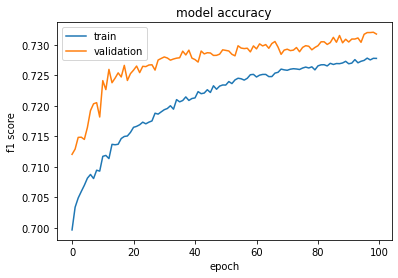

In [63]:
plt.plot(model_history.history['f1_score'])
plt.plot(model_history.history['val_f1_score'])
plt.title('model accuracy')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### 2.2) Analise Exploratoria

In [ ]:
plt.figure(figsize=(10,5))
df_plot = pd.DataFrame(df_train["labels"].value_counts()).reset_index()

fig = px.bar(df_plot, x='index', y='labels')
fig.show()

<Figure size 720x360 with 0 Axes>

#### Analise Duplicados

In [ ]:
! pip install imagehash

     |████████████████████████████████| 812 kB 5.3 MB/s 
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295207 sha256=8ae35b9a27402e186e860f09dac23554553ef350ba16d1cb85a3a5f6672c4da6
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533ddb09407769762985d134135064c6831e29a914e
Successfully built imagehash


In [ ]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imagehash
import PIL
import os

In [ ]:
class CFG():
    
    threshold = .9
    img_size = 512
    seed = 42

In [ ]:
paths = os.listdir("/projeto_final/train_images/")

try:
  os.mkdir("/projeto_final/train_images_small")
except:
  pass

In [ ]:
for path in tqdm(paths, total=len(paths)):
  image = tf.io.read_file(os.path.join("/projeto_final/train_images/", path))
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [CFG.img_size, CFG.img_size])
  image = tf.cast(image, tf.uint8).numpy()
  plt.imsave("/projeto_final/train_images_small/"+path, image)

  0%|          | 0/18632 [00:00<?, ?it/s]

In [ ]:
hash_functions = [
    imagehash.average_hash,
    imagehash.phash,
    imagehash.dhash,
    imagehash.whash]

image_ids = []
hashes = []

paths = tf.io.gfile.glob('/projeto_final/train_images_small/*.jpg')

for path in tqdm(paths, total=len(paths)):

    image = PIL.Image.open(path)

    hashes.append(np.array([x(image).hash for x in hash_functions]).reshape(-1,))
    image_ids.append(path.split('/')[-1])
    
hashes = np.array(hashes)
image_ids = np.array(image_ids)

  0%|          | 0/18632 [00:00<?, ?it/s]

In [ ]:
duplicate_ids = []

for i in tqdm(range(len(hashes)), total=len(hashes)):
    similarity = (hashes[i] == hashes).mean(axis=1)
    duplicate_ids.append(list(image_ids[similarity > CFG.threshold]))
    
duplicates = [frozenset([x] + y) for x, y in zip(image_ids, duplicate_ids)]
duplicates = set([x for x in duplicates if len(x) > 1])



  0%|          | 0/18632 [00:00<?, ?it/s]

In [ ]:
print(f'Found {len(duplicates)} duplicate pairs:')
for row in duplicates:
    print(', '.join(row))

Found 50 duplicate pairs:
83e3d2329933c5f2.jpg, 83e3d2369933c5d2.jpg
9ada65c5b0cc9a3c.jpg, e9e8ad35c5871d06.jpg
abb0d5a9d4b4985c.jpg, ab91d1a9d4b49a6c.jpg
d89c9cda9274322f.jpg, d89d9ede82743229.jpg
c9d63696629107ed.jpg, 8f5263c61a8cdbe2.jpg
aa542048ebf78bf4.jpg, aa142048eff78bf4.jpg
8c0731fff680c51e.jpg, df90901ccb664de6.jpg
e11be7f110de8f80.jpg, e13be7f1105e8f80.jpg
e51690d8ad307dcb.jpg, eec64e8cf1c8d0c6.jpg
d2266ac99461e9db.jpg, c1753cad2f31d492.jpg
a3bb604d8a55995d.jpg, e7ecc583d571d202.jpg
d0c766bc38e1978c.jpg, e83f715e56462a31.jpg
c738d13e7146798c.jpg, c738d13e73467988.jpg
98864714f96a75d5.jpg, 9886c704f93a79b3.jpg
90f99ee1c1132bb6.jpg, 94c83b2d5fad6924.jpg
a9b2e4b09297bc2b.jpg, d1f01e8d8a73274d.jpg
9fad869f21b5b240.jpg, d7ec32d72c84dc18.jpg
f6f1160be38a48d5.jpg, f6f11e0fe38a08c5.jpg
c5339e87235c6ac5.jpg, c53b9e87215c6ac5.jpg
c5aff2e545d0a129.jpg, dbee22785d9285c4.jpg
e22e9a365cd1ea58.jpg, e22e8a365cd1ea5c.jpg
f0cb859beb1b30c1.jpg, f0cb879e4a1b35c1.jpg
ca782c131f5ce0fc.jpg, e5f273

In [ ]:
# Criando csv de duplicados e salvando no drive

with open("drive/MyDrive/projeto_final_dups.csv", "w") as file:
  for row in duplicates:
    file.write(";".join(row)+"\n")

Referencia
https://www.kaggle.com/nickuzmenkov/pp2021-ultimate-preprocessing

### Ler duplicados do csv ja salvo

In [ ]:
df_dups = pd.read_csv("drive/MyDrive/projeto_final_dups.csv", sep=";", names=["img_1", "img_2"])

In [ ]:
df_dups_cat = df_dups.merge(df_train[["image","label_list"]], left_on="img_1", right_on="image", how="left")
df_dups_cat.drop("image",axis = 1, inplace=True)
df_dups_cat.rename(columns={"label_list":"labels_1"},inplace=True)

In [ ]:
df_dups_cat = df_dups_cat.merge(df_train[["image","label_list"]], left_on="img_2", right_on="image", how="left")
df_dups_cat.drop("image",axis = 1, inplace=True)
df_dups_cat.rename(columns={"label_list":"labels_2"},inplace=True)

In [ ]:
df_dups_cat["flag_dif_label"] = df_dups_cat["labels_1"] != df_dups_cat["labels_2"]

In [ ]:
# Nem todas as imagens tem os mesmos labels associdos a elas
df_dups_cat["flag_dif_label"].value_counts()

True     27
False    23
Name: flag_dif_label, dtype: int64

In [ ]:
df_dups_cat.head()

,img_1,img_2,labels_1,labels_2,flag_dif_label
0,83e3d2329933c5f2.jpg,83e3d2369933c5d2.jpg,[scab],[scab],False
1,9ada65c5b0cc9a3c.jpg,e9e8ad35c5871d06.jpg,[complex],[rust],True
2,abb0d5a9d4b4985c.jpg,ab91d1a9d4b49a6c.jpg,[rust],[rust],False
3,d89c9cda9274322f.jpg,d89d9ede82743229.jpg,[rust],[rust],False
4,c9d63696629107ed.jpg,8f5263c61a8cdbe2.jpg,[complex],[rust],True


In [ ]:
def ret_img(image_name, path:str):
  img = mpimage.imread(path + image_name)
  return img


def plot_duplicates(df_dup:pd.DataFrame, rownum:int, path:str)-> None:
  image_name_0 = df_dup["img_1"].loc[rownum]
  image_name_1 = df_dup["img_2"].loc[rownum]
  
  label_0 = df_dup["labels_1"].loc[rownum]
  label_1 = df_dup["labels_2"].loc[rownum]

  plt.figure(figsize=(9,4))
  plt.subplot(121)
  plt.imshow(ret_img(image_name_0 ,path= path))
  plt.title('{} - {}'.format(image_name_0, label_0))
  plt.subplot(122)
  #n = lst_img[1]
  plt.imshow(ret_img(image_name_1 ,path= path))
  plt.title('{} - {}'.format(image_name_1, label_1))
  plt.tight_layout()


NameError: ignored

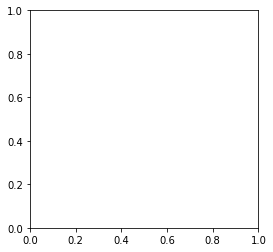

In [ ]:
df_dups_diff = df_dups_cat[df_dups_cat["flag_dif_label"]==True].reset_index(drop=True)
df_len = df_dups_diff.shape[0]
path = "../projeto_final/train_images/"

for rownum in range(df_len-1):
  plot_duplicates(df_dups_diff, rownum, path=path)

In [ ]:
print("image_1")
df_dups_cat[df_dups_cat["flag_dif_label"] == True]["labels_1"].str.join(sep=",").value_counts()

In [ ]:
print("image_2")
df_dups_cat[df_dups_cat["flag_dif_label"] == True]["labels_2"].str.join(sep=",").value_counts()

In [ ]:
df_dups_cat["labels_1_str"] = df_dups_cat["labels_1"].str.join(sep=",")
df_dups_cat["labels_2_str"] = df_dups_cat["labels_2"].str.join(sep=",")

In [ ]:
pd.DataFrame(df_dups_cat.groupby(["labels_1_str", "labels_2_str"])["flag_dif_label"].count())

flag_dif_label
labels_1_str            labels_2_str                      
complex                 complex                          1
                        rust                            11
frog_eye_leaf_spot      frog_eye_leaf_spot               1
rust                    complex                          9
                        rust                            18
                        rust,complex                     3
rust,complex            rust                             3
rust,frog_eye_leaf_spot rust                             1
scab                    scab                             3

In [ ]:
#-------- Alternativa 1 --------
# Tratamento 1 de imagens Duplicadas
# Aquelas que tem a mesma classe apenas irei pegar apenas uma delas por distinct
# As que tem labels diferentes serao removidos do dataset (total de 27 imagens - penalizamos bem a classe Rust, Complex)

img_exclusion = df_dups_cat[df_dups_cat["flag_dif_label"] == False]["img_2"]
ds1 = df_dups_cat[df_dups_cat["flag_dif_label"] == True]["img_1"]
ds2 = df_dups_cat[df_dups_cat["flag_dif_label"] == True]["img_2"]

img_exclusion = pd.concat([ds1, ds2, img_exclusion], axis=0).reset_index(drop=True)

df_exc = pd.DataFrame(img_exclusion)
df_exc["flag_exc"] = 1

df_exc.columns = ['img_exc', 'flag_exc']

In [ ]:
df_train = df_train.merge(df_exc, how="left", left_on="image", right_on="img_exc", )

In [ ]:
# Dataset filtrado retirando os duplicados

filter = df_train["flag_exc"]==0

df_train_filtered = df_train[filter]

### Carregando dataset para formato Lazy

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255.,
    #rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True,
    validation_split = 0.2,
    #zoom_range = 0.2,
    #shear_range = 0.2,
    #vertical_flip = False
    )

In [ ]:
df_train.head()

,image,labels,label_list,healthy,scab,complex,rust,frog_eye_leaf_spot,powdery_mildew,img_exc,flag_exc
0,800113bb65efe69e.jpg,healthy,[healthy],1,0,0,0,0,0,NaN,NaN
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,"[scab, frog_eye_leaf_spot, complex]",0,1,1,0,1,0,NaN,NaN
2,80070f7fb5e2ccaa.jpg,scab,[scab],0,1,0,0,0,0,NaN,NaN
3,80077517781fb94f.jpg,scab,[scab],0,1,0,0,0,0,NaN,NaN
4,800cbf0ff87721f8.jpg,complex,[complex],0,0,1,0,0,0,NaN,NaN


In [ ]:
HEIGHT = 512
WIDTH=512
SEED = 42
BATCH_SIZE= 128

df_train_filtered = df_train[["image", "labels"]]

train_dataset = train_datagen.flow_from_dataframe(
    df_train_filtered,
    directory = "/projeto_final/train_images/",
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "training",
    shuffle = True,
    seed = SEED,
    validate_filenames = False)

validation_dataset = train_datagen.flow_from_dataframe(
    df_train_filtered,
    directory = "/projeto_final/train_images/",
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "validation",
    shuffle = True,
    seed = SEED,
    validate_filenames = False)


Found 14906 non-validated image filenames belonging to 12 classes.
Found 3726 non-validated image filenames belonging to 12 classes.


In [ ]:
# Carregamento do modelo pré-treinado SEM as camadas densas (include_top = False)
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(512,512,3)) # 32 x 32 (?)
model.summary()

# Congela camadas pré-treinadas
for layer in model.layers:
    layer.trainable = False

# Insere novas camadas no fim da rede para classificação
frozen_model = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(12, activation='softmax')
])

frozen_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
# Instancia um otimizador SGD, compila e treina o modelo completo
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.001, nesterov=True)


# Early Stopping
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

frozen_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

frozen_model.fit(train_dataset, epochs=25,
                  validation_data=validation_dataset,
                 callbacks=[early,
                            tf.keras.callbacks.experimental.BackupAndRestore(backup_dir="/drive/MyDrive/trabalho_final_mdc")])

NameError: ignored

# TO DO

* Analise expectral de cores
* Tentar inputar no modelo simples de rede neural
* Imputar no Resnet50

In [ ]:
! cd drive/MyDrive; ls

 20180529_playerdetection.py
 amz
 Apresentacao.pptx
'Aulas Digital House - Pie chart 1.gsheet'
 auxilio
 b3
 backup
'Backup Iphone'
 Bolo.gsheet
 Books
'Canada 2022'
'Case Nubank'
'Climbing Workout.gsheet'
'Colab Notebooks'
 Cookies.gsheet
'Cópia de [BÔNUS] PlantLife School - Modelo de ficha técnica de produção.gsheet'
'Copy of IMG_1029.JPG'
'Coursera '
'Coursera Week 1 - Task 1.gsheet'
 deep_trabalho_2
'Digital House'
'Documento sem título.gdoc'
'Draft Projeto Final.gdoc'
'Draft Trabalho Final.gdoc'
'Fotos Ba'
'Gastos Viagem (1).gsheet'
'Gastos Viagem.gsheet'
 gut-pt
'gut-pt (1)'
 IAR_11048712.pdf
 IFTTT
 imposto.gsheet
'Kami Uploads'
"Let's Go Somewhere.gsheet"
'Mapeamento Bases P..gsheet'
 MBB
 mdc-2021-eae446dab2de.json
'Meus Gastos Mensais.gsheet'
'Otaku life.gsheet'
 Photos
'Pokemon (1).gsheet'
 Pokemon.csv
 Pokemon.gsheet
 projeto_final_dups.csv
'Projetos MDC.gsheet'
'Rotina Quarentena.gsheet'
 SVHN_Dataset
 T01_MDC010_INF0614_Kurosawa_Suda_Wakabayashi.gdoc
 T01_MDC010_IN